In [1]:
pip install openpyxl

     |████████████████████████████████| 242 kB 893 kB/s            
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import seaborn as sns
import fasttext
from nltk.util import ngrams
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
import numpy as np
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Embedding,GRU,LSTM,Bidirectional,Dropout,Conv1D,MaxPooling1D,GlobalAveragePooling1D,Flatten,Input
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score,classification_report
from keras.callbacks import EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
import gensim
from tqdm import tqdm
from gensim.models import word2vec
from sklearn import metrics


### Import excel file for Nile_Basin countries

In [3]:
df=pd.read_excel("../input/data-arabic-dialect/data_nile_basin.xlsx",index_col=0,
              dtype={'tokens': str, 'dialect': str})
## check the presence of null values
df.isna().sum()

tokens     0
dialect    0
dtype: int64

In [4]:
## reset index
df=df.reset_index()
df.drop('index',axis=1,inplace=True)

### count numbers of sentences that belong to each country

Index(['EG', 'SD'], dtype='object')


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='dialect'>

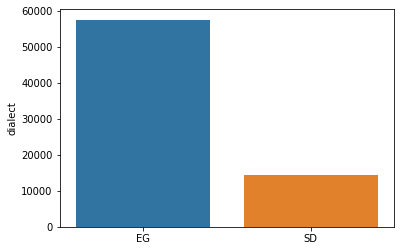

In [5]:
x=df['dialect'].value_counts()
print(x.index)
sns.barplot(x.index,x)

### compute the max number of words ( max_length of the sentence)

In [6]:
def splitolist(data):
    l=data.split(" ")
    return l

In [7]:
df['tokens1']=df['tokens'].apply(splitolist)

In [8]:
max_length=df.tokens1.str.len().max()
print("max length is"+" "+str(max_length))


max length is 54


In [9]:
df.loc[0,['tokens','dialect']][0]

'الاقيش معاك الف يا عم نجيب قرض حسن ابدا بيهم حلمي وهسدهم عاوز تشاركني هسدهم بارضو وتبقى شريك بالربع'

### create a corpus of the entire dataset in a txt file

In [10]:
with open(r'./corpus.txt', 'w', encoding='utf-8') as txtfile:
    for i in range(len(df)):
        line = df.loc[i,'tokens']
        txtfile.write(line)
        txtfile.write('\n')

### train skipgram model on the corpus to get word embeddings

In [11]:
EMBED_SIZE=100
model = fasttext.train_unsupervised('./corpus.txt',
                                    minCount = 5, 
                                    model='skipgram',
                                    minn = 2,
                                    maxn = 5,
                                    dim = 100,
                                    lr = 0.1,
                                    epoch = 10)

Read 0M words
Number of words:  21252
Number of labels: 0
Progress: 100.0% words/sec/thread:   99501 lr:  0.000000 avg.loss:  1.659903 ETA:   0h 0m 0s


In [12]:
#create a list of all unique words in the dataset
with open(r'./corpus.txt', 'r', encoding="utf-8") as txtfile:
    corpus_sentences = txtfile.readlines()
    corpus_words = []
    for sent in corpus_sentences:
        tokenized_sent = sent.split()
        for word_ in tokenized_sent:
            corpus_words.append(word_)
            
    corpus_unique_words = list(set(corpus_words))

### convert text to numbers using tokenizer

In [13]:
tokenizer = Tokenizer(num_words=len(corpus_unique_words)+1)
tokenizer.fit_on_texts(df['tokens'])
sequences = tokenizer.texts_to_sequences(df['tokens'])

In [14]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=max_length,padding='post')  ## padding all the sentences in the dataset to have the same length

Found 130101 unique tokens.


### create embedding matrix from the trained fasttext model

In [15]:
vocab_size = len(tokenizer.word_index)+1
embeddings_matrix = np.zeros(shape = (vocab_size , EMBED_SIZE))

for word, index in tqdm(tokenizer.word_index.items()):
    embeddings_matrix[index] = model.get_word_vector(word)

100%|██████████| 130101/130101 [00:01<00:00, 81004.87it/s]


In [16]:
data_y=pd.get_dummies(df['dialect'])

In [17]:
data_y[:10]

,EG,SD
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
5,1,0
6,1,0
7,1,0
8,1,0
9,1,0


In [18]:
#split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(data,data_y, test_size = 0.1, stratify =data_y,shuffle=True)

In [19]:
#create a bidirectional LSTM model
def create_model():
    model = Sequential()
    embedding_layer = Embedding(vocab_size, EMBED_SIZE, 
                                weights=[embeddings_matrix], 
                                input_length=max_length , 
                                trainable=True)
    
    model.add(embedding_layer)
    model.add(Bidirectional(LSTM(128)))
    model.add(Dropout(0.5))
    model.add(Dense(5000, activation='relu'))
    model.add(Dense(len(np.unique(df['dialect'])), activation='softmax'))
    return model

model1 = create_model()
tf.keras.backend.clear_session()
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss',mode = 'max',patience=3,verbose=1) #,mode = 'min',callbacks=[early_stop]
early_stopping = EarlyStopping(monitor='loss', patience=2)
tf.keras.backend.clear_session()
# early_stopping = EarlyStopping(monitor= 'val_acc', 
#                                mode = 'max',
#                                patience=30, 
#                                verbose=1)

# model_checkpoint = ModelCheckpoint('levant_dialect_CLASSIFIER',
#                                    monitor = 'val_acc', 
#                                    mode = 'max', 
#                                    save_best_only=True, 
#                                    verbose=1)


opt = Adam(learning_rate = 0.0001)

model1.compile(opt, loss = 'categorical_crossentropy', metrics=['accuracy'])

2022-03-13 21:03:16.071422: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-13 21:03:16.174609: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-13 21:03:16.175434: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-13 21:03:16.176550: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [20]:
np.unique(df['dialect']).tolist()

['EG', 'SD']

In [21]:
#train the model
history = model1.fit(x_train, 
                    y_train, 
                    validation_data=(x_test, y_test),
                    batch_size=32,
                    epochs=50,
                    callbacks = [early_stop])

2022-03-13 21:03:19.216217: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-03-13 21:03:22.337616: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2026/2026 [==============================] - 29s 12ms/step - loss: 0.3251 - accuracy: 0.8648 - val_loss: 0.2476 - val_accuracy: 0.9013
Epoch 2/50
2026/2026 [==============================] - 24s 12ms/step - loss: 0.2215 - accuracy: 0.9109 - val_loss: 0.2235 - val_accuracy: 0.9102
Epoch 3/50
2026/2026 [==============================] - 24s 12ms/step - loss: 0.1781 - accuracy: 0.9295 - val_loss: 0.2161 - val_accuracy: 0.9154
Epoch 4/50
2026/2026 [==============================] - 24s 12ms/step - loss: 0.1434 - accuracy: 0.9450 - val_loss: 0.2242 - val_accuracy: 0.9131
Epoch 00004: early stopping


In [22]:
model1.save("Nile_Basin.h5")

In [23]:
target_names=np.unique(df['dialect']).tolist()
target_names

['EG', 'SD']

In [24]:
y_test

,EG,SD
33518,1,0
3035,1,0
10938,1,0
67648,0,1
28353,1,0
...,...,...
50794,1,0
19009,1,0
25192,1,0
20014,1,0


In [25]:
np.argmax(np.array(y_test),axis=1)

array([0, 0, 0, ..., 0, 0, 0])

### classification report for test data

In [26]:
pred=model1.predict(x_test)
print(classification_report(np.argmax(np.array(y_test),axis=1),np.argmax(pred,axis=1), target_names=target_names))

              precision    recall  f1-score   support

          EG       0.95      0.95      0.95      5762
          SD       0.78      0.78      0.78      1440

    accuracy                           0.91      7202
   macro avg       0.86      0.86      0.86      7202
weighted avg       0.91      0.91      0.91      7202



### classification report for train data

In [27]:
pred_train=model1.predict(x_train)
print(classification_report(np.argmax(np.array(y_train),axis=1),np.argmax(pred_train,axis=1), target_names=target_names))

              precision    recall  f1-score   support

          EG       0.98      0.97      0.97     51859
          SD       0.89      0.90      0.90     12957

    accuracy                           0.96     64816
   macro avg       0.93      0.94      0.93     64816
weighted avg       0.96      0.96      0.96     64816



In [ ]:
print(pred_train)

In [32]:
a="عامل ايه"
l=splitolist(a)
seq=tokenizer.texts_to_sequences(l)
b=[item for sublist in seq for item in sublist]
print(b)
pad_seq=pad_sequences([b], maxlen=max_length,padding='post')

[274, 8]


In [33]:
print(l,seq,pad_seq)

['عامل', 'ايه'] [[274], [8]] [[274   8   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]]


In [34]:
out=model1.predict(pad_seq).argmax(axis=1)
out[0]

0

In [35]:
country_pred=target_names[out[0]]
country_pred

'EG'